In [1]:
import numpy as np
import tensorflow as tf
import h5py
import os
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import cv2
from PIL import Image
from skimage.measure import compare_ssim,compare_psnr

In [2]:
def show_data(x_in, pre_in):
    mean = np.mean(x_in)
    std = np.std(x_in)
    Max = np.max(x_in)
    Min = np.min(x_in)
    dtype = x_in.dtype
    
    print(pre_in + ' shape: ' + str(x_in.shape) + ' , type: ' + str(dtype) + ' , mean = ' + str(mean) 
          + ' , std = ' + str(std) + ' , Max = ' + str(Max) + ' , Min = ' + str(Min))

In [3]:
def trans_PNG(data,iname):
    im = Image.fromarray(data)
    im.save(iname,compress_level=0)

In [4]:
Nx=1024
Ny=1536
NC = 1

NX = 2048
NY = 3072

block_size = 8
stride_size = 8
ncomp = 4

sc_int=21.
Q_scale=1.

Trained_model = {}
Trained_model[0] = './model_R/model_200000.ckpt-200001'
Trained_model[1] = './model_G/model_200000.ckpt-200001'
Trained_model[2] = './model_B/model_200000.ckpt-200001'

codes = {}
f_code=h5py.File('./code_884_1x16_4bit_RcKD.h5','r')
code=f_code['data'][:]
codes[0]=code.astype(np.float32)

f_code=h5py.File('./code_884_1x16_4bit_GcKD.h5','r')
code=f_code['data'][:]
codes[1]=code.astype(np.float32)

f_code=h5py.File('./code_884_1x16_4bit_BcKD.h5','r')
code=f_code['data'][:]
codes[2]=code.astype(np.float32)

for i in range(3):
    show_data(codes[i], 'codes_' + str(i))

print('')

scopes = {}
scopes[0] = 'Decomp_NN_884_fix_code_RB_c0_RcKD'
scopes[1] = 'Decomp_NN_884_fix_code_RB_c0_GcKD'
scopes[2] = 'Decomp_NN_884_fix_code_RB_c0_BcKD'
for i in range(3):
    print('scope' + str(i) + ': ' + scopes[i])

codes_0 shape: (8, 8, 1, 4) , type: float32 , mean = 1.0898438 , std = 2.1713095 , Max = 7.0 , Min = -3.0
codes_1 shape: (8, 8, 1, 4) , type: float32 , mean = 0.69140625 , std = 2.4722056 , Max = 6.0 , Min = -5.0
codes_2 shape: (8, 8, 1, 4) , type: float32 , mean = 0.015625 , std = 2.5662606 , Max = 7.0 , Min = -6.0

scope0: Decomp_NN_884_fix_code_RB_c0_RcKD
scope1: Decomp_NN_884_fix_code_RB_c0_GcKD
scope2: Decomp_NN_884_fix_code_RB_c0_BcKD


In [5]:
def compression(Data_in, code_in, stride_size, Q_scale, sc_int, Q_type):
    compW = tf.constant(code_in)

    comp = tf.nn.conv2d(Data_in, compW, strides=[1, stride_size, stride_size, 1], padding='VALID')
    print(comp)

    compm = comp*Q_scale
    print(compm)

    compint = tf.cast(compm,Q_type)
    print(compint)

    compf32 = tf.cast(compint,tf.float32)/(sc_int*Q_scale)
    print(compf32)

    return compf32

In [6]:
def residual_block(input_tense):
    tmp1 = tf.nn.relu(tf.layers.batch_normalization(
        tf.layers.conv2d(input_tense,64,[3,3],[1,1], padding='SAME')))
    tmp2 = tf.nn.relu(tf.layers.batch_normalization(
        tf.layers.conv2d(tmp1,16,[2,2],[1,1], padding='SAME')))
    tmp3 = tf.layers.batch_normalization(
        tf.layers.conv2d(tmp2,1,[1,1],[1,1], padding='SAME'))
    tmp4 = tmp3 + input_tense
    return tmp4

In [7]:
from xy_inception_tf_model_actv import inception_module,inception_model

def recon_NN(comp_in, NC, block_size, stride_size, scope, reuse=False):
    with tf.variable_scope(scope, reuse=reuse):

        with tf.name_scope('Pre_dcomp'):
            pdcomp = residual_block(comp_in)
            print(pdcomp)

        with tf.name_scope('Dcompress_Conv'):
            dcomp = tf.layers.conv2d_transpose(pdcomp,NC,[block_size,block_size],[stride_size,stride_size], padding='VALID')
            print(dcomp)


        with tf.name_scope('inception_model'):
            outputs=inception_model(dcomp, 8, tf.sigmoid)

        return outputs

In [8]:
with tf.name_scope('DATA'):
    Data_in = tf.placeholder(tf.float32,shape=[None,Nx,Ny,NC])
    print(Data_in)

Tensor("DATA/Placeholder:0", shape=(?, 1024, 1536, 1), dtype=float32)


In [9]:
comp_o={}
for i in range(3):
    comp_o[i]=compression(Data_in, codes[i], stride_size, Q_scale, sc_int, tf.int8)
    print(comp_o[i])
    print('')

Tensor("Conv2D:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("mul:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("Cast:0", shape=(?, 128, 192, 4), dtype=int8)
Tensor("truediv:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("truediv:0", shape=(?, 128, 192, 4), dtype=float32)

Tensor("Conv2D_1:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("mul_1:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("Cast_2:0", shape=(?, 128, 192, 4), dtype=int8)
Tensor("truediv_1:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("truediv_1:0", shape=(?, 128, 192, 4), dtype=float32)

Tensor("Conv2D_2:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("mul_2:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("Cast_4:0", shape=(?, 128, 192, 4), dtype=int8)
Tensor("truediv_2:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("truediv_2:0", shape=(?, 128, 192, 4), dtype=float32)



In [10]:
Recs = {}
for i in range(3):
    Recs[i]=recon_NN(comp_o[i], NC, block_size, stride_size, scopes[i])
    print("\nRecs[" + str(i) + "]: " + str(Recs[i]))
    print('\n')

Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/Pre_dcomp/add:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/Dcompress_Conv/conv2d_transpose/BiasAdd:0", shape=(?, 1024, 1536, 1), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/inception_model/conv2d/BiasAdd:0", shape=(?, 1024, 1536, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/inception_model/batch_normalization/FusedBatchNorm:0", shape=(?, 1024, 1536, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/inception_model/conv2d_1/BiasAdd:0", shape=(?, 1024, 1536, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/inception_model/batch_normalization_1/FusedBatchNorm:0", shape=(?, 1024, 1536, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/inception_model/LeakyRelu/Maximum:0", shape=(?, 1024, 1536, 96), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/inception_model/inception_modules_0/conv2d/BiasAdd:0", shape=(?, 1024, 1536, 64), dtype=fl

Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/Pre_dcomp/add:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/Dcompress_Conv/conv2d_transpose/BiasAdd:0", shape=(?, 1024, 1536, 1), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/inception_model/conv2d/BiasAdd:0", shape=(?, 1024, 1536, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/inception_model/batch_normalization/FusedBatchNorm:0", shape=(?, 1024, 1536, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/inception_model/conv2d_1/BiasAdd:0", shape=(?, 1024, 1536, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/inception_model/batch_normalization_1/FusedBatchNorm:0", shape=(?, 1024, 1536, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/inception_model/LeakyRelu/Maximum:0", shape=(?, 1024, 1536, 96), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_GcKD/inception_model/inception_modules_0/conv2d/BiasAdd:0", shape=(?, 1024, 1536, 64), dtype=fl

Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/Pre_dcomp/add:0", shape=(?, 128, 192, 4), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/Dcompress_Conv/conv2d_transpose/BiasAdd:0", shape=(?, 1024, 1536, 1), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/inception_model/conv2d/BiasAdd:0", shape=(?, 1024, 1536, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/inception_model/batch_normalization/FusedBatchNorm:0", shape=(?, 1024, 1536, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/inception_model/conv2d_1/BiasAdd:0", shape=(?, 1024, 1536, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/inception_model/batch_normalization_1/FusedBatchNorm:0", shape=(?, 1024, 1536, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/inception_model/LeakyRelu/Maximum:0", shape=(?, 1024, 1536, 96), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_c0_BcKD/inception_model/inception_modules_0/conv2d/BiasAdd:0", shape=(?, 1024, 1536, 64), dtype=fl

In [11]:
var_s = {}
for i in range(3):
    var_s[i] = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopes[i])
    print('var_s_' + str(i) + ':\n')
    print(var_s[i])
    print('\n')

var_s_0:

[<tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/conv2d/kernel:0' shape=(3, 3, 4, 64) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/conv2d/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/conv2d_1/kernel:0' shape=(2, 2, 64, 16) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/batch_normalization_1/gamma:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/batch_normalization_1/beta:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB_c0_RcKD/conv2d_2/kernel:0' shape=(1, 1, 16, 1) dtype=float32_ref>, <tf.Variable 'Decomp_NN_884_fix_code_RB

In [12]:
savers = {}
for i in range(3):
    savers[i] = tf.train.Saver(var_list=var_s[i])
    print('savers_' + str(i) + ':')
    print(str(savers[i]))
    print('\n')

savers_0:


savers_1:


savers_2:




In [13]:
init = tf.global_variables_initializer()

In [14]:
def run_recon(data_in, Rec_in, trained_model, saver_in):
    with tf.Session() as sess:
        sess.run(init)
        saver_in.restore(sess,trained_model)
        dip=sess.run(Rec_in,feed_dict={Data_in:data_in})
            
    return dip

In [15]:
xs_s={}; ys_s={};

xs_s[0]=0; ys_s[0]=0
xs_s[1]=Nx; ys_s[1]=0
xs_s[2]=0; ys_s[2]=Ny
xs_s[3]=Nx; ys_s[3]=Ny

for i in range(4):
    print(str(i) + " xs= " + str(xs_s[i]) + " , ys= " + str(ys_s[i]))

0 xs= 0 , ys= 0
1 xs= 1024 , ys= 0
2 xs= 0 , ys= 1536
3 xs= 1024 , ys= 1536


In [16]:
def big_frame_recon(data_in, Rec_in, trained_model, saver_in):
    print('big_frame_recon, Rec_in: ' + str(Rec_in))
    Dips={}
    for i in range(4):
        xs=xs_s[i]; xe=xs+Nx
        ys=ys_s[i]; ye=ys+Ny
        data_f=np.zeros([1,Nx,Ny,NC])
        data_f[0,:,:,0]=data_in[xs:xe,ys:ye]
        Dips[i]=run_recon(data_f, Rec_in, trained_model, saver_in)
        
    shape_o=[NX,NY]
    Dip=np.zeros(shape_o)
    for i in range(4):
        xs=xs_s[i]; xe=xs+Nx
        ys=ys_s[i]; ye=ys+Ny
        Dip[xs:xe,ys:ye]=Dips[i][0,:,:,0]
        
    return Dip

In [17]:
def kd_fname(i_in):
    rname = '/IMG000' + str(i_in) + '.dib'
    if i_in >9: rname = '/IMG00' + str(i_in) + '.dib'
        
    return rname

In [18]:
pref = '../Kodak_examples_uncompressed'

In [19]:
Ns_t = 1
Ne_t = 4
Nf_t = 3

In [20]:
Data_t = np.zeros([Nf_t,2048,3072,3])
recon_t = np.zeros([Nf_t,2048,3072,3])
inm = 0 #model number
i_n=0
for i in range(Ns_t, Ne_t):
    fname = pref + kd_fname(i)
    print(fname)
    tim = cv2.imread(fname)
    
    for inc in range(3):
        print('channel' + str(inc))
        timt = tim[...,inc]
    
        npix = timt.shape[0]*timt.shape[1]
        assert(npix == 2048*3072)
        if timt.shape[0]!=2048: timt = np.rot90(timt,k=1)
    
        show_data(timt, '  image')
    
        Data_t[i_n,:,:,inc] = timt.astype(np.float)/255.0
        show_data(Data_t[i_n,:,:,inc], '  Data_t')
    
        recon_t[i_n,:,:,inc] = big_frame_recon(Data_t[i_n,:,:,inc], Recs[inc], Trained_model[inc], savers[inc])
        show_data(recon_t[i_n,:,:,inc], '  recon_t')
    
        mse=np.mean(np.square(Data_t[i_n,:,:,inc]-recon_t[i_n,:,:,inc]))
        print("  mse = " + str(mse) + '\n')
    
    print("\n")
    
    i_n = i_n+1

../Kodak_examples_uncompressed/IMG0001.dib
channel0
  image shape: (2048, 3072) , type: uint8 , mean = 87.41269111633301 , std = 48.138943111710766 , Max = 249 , Min = 0
  Data_t shape: (2048, 3072) , type: float64 , mean = 0.3427948671228745 , std = 0.18878016906553044 , Max = 0.9764705882352941 , Min = 0.0
big_frame_recon, Rec_in: Tensor("Decomp_NN_884_fix_code_RB_c0_RcKD/inception_model/conv2d_3/Sigmoid:0", shape=(?, 1024, 1536, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model_R/model_200000.ckpt-200001
INFO:tensorflow:Restoring parameters from ./model_R/model_200000.ckpt-200001
INFO:tensorflow:Restoring parameters from ./model_R/model_200000.ckpt-200001
INFO:tensorflow:Restoring parameters from ./model_R/model_200000.ckpt-200001
  recon_t shape: (2048, 3072) , type: float64 , mean = 0.342728568444314 , std = 0.18841981044340175 , Max = 0.9376857280731201 , Min = 0.00041995602077804506
  mse = 0.00020462575722353274

channel1
  image shape: (2048, 3072) , type: u

0
  psnr= 36.28700072236011 , ssim= 0.9060830104880515


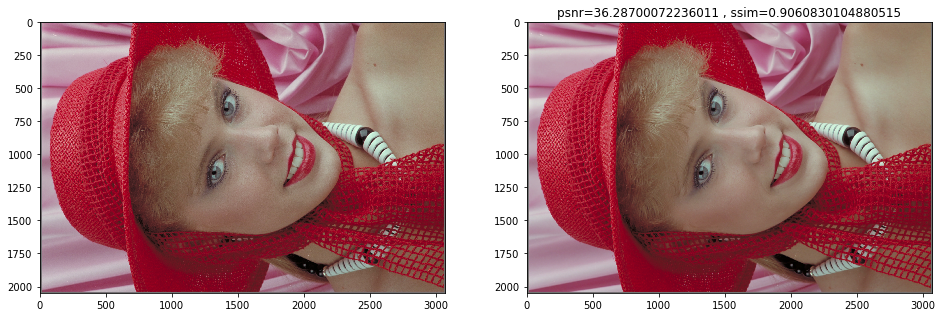

1
  psnr= 34.8445130876413 , ssim= 0.8828912716591083


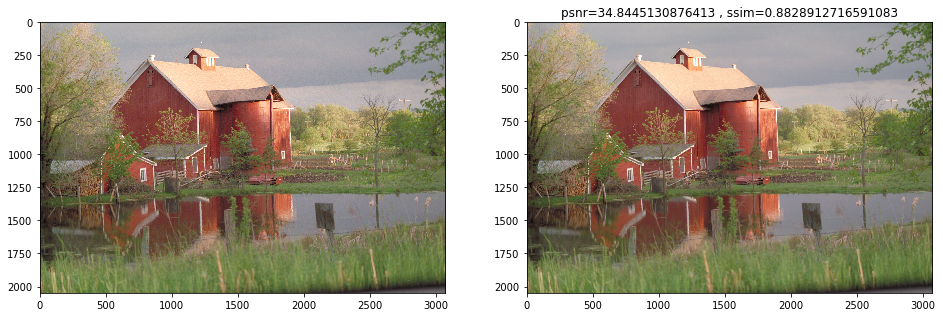

2
  psnr= 39.39019193376164 , ssim= 0.9282110552361861


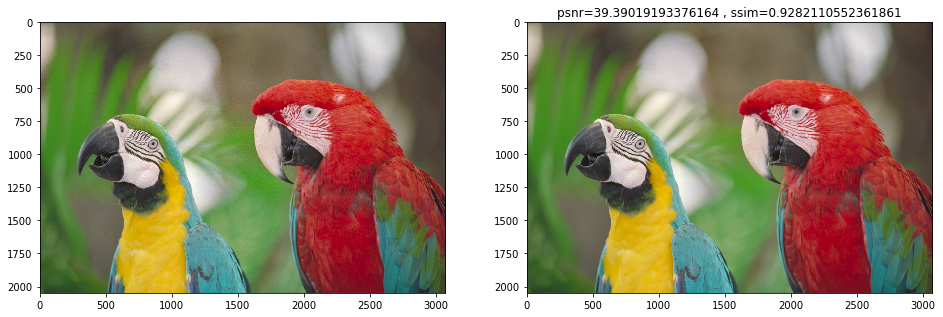

In [22]:
pre_o_s = './KD_orig/'
pre_r_s = './KD_884/'
for i in range(Nf_t): #Nf_t
    print(i)
    
    label = np.zeros([Data_t.shape[1], Data_t.shape[2],3])
    recon = np.zeros([Data_t.shape[1], Data_t.shape[2],3])
    label[...,0] = Data_t[i,:,:,2]; recon[...,0] = recon_t[i,:,:,2]
    label[...,1] = Data_t[i,:,:,1]; recon[...,1] = recon_t[i,:,:,1]
    label[...,2] = Data_t[i,:,:,0]; recon[...,2] = recon_t[i,:,:,0]
    label = (label*255).astype('uint8')
    recon = (recon*255).astype('uint8')
    
    psnr =compare_psnr(recon, label)
    ssim =compare_ssim(recon, label, multichannel=True)
    print("  psnr= " + str(psnr) + " , ssim= " + str(ssim))
    
    plt.figure(figsize=(16, 18))

    plt.subplot(1,2,1)
    plt.imshow(label)
    
    plt.subplot(1,2,2)    
    plt.imshow(recon)
    plt.title('psnr=' + str(psnr) + " , ssim=" +str(ssim))
    plt.show()
    
    idx = i+1
    oname = pre_o_s + str(idx) + '.png'
    rname = pre_r_s + str(idx) + '.png'
    trans_PNG(label,oname)
    trans_PNG(recon,rname)
    